In [2]:
import numpy as np
from random import random
from matplotlib import pyplot as plt

In [3]:
def el_2(xi):
    """Renvoie exp(i*xi*lambda_2)"""
    return np.array([[np.cos(xi), np.sin(xi), 0],
                     [-np.sin(xi), np.cos(xi), 0],
                     [0,0,1]])

In [4]:
def el_5(xi):
    return np.array([[np.cos(xi), 0, np.sin(xi)],
                     [0,1,0],
                     [-np.sin(xi), 0,np.cos(xi)]])

In [5]:
def el_3(xi):
    return np.array([[np.exp(xi*1j), 0, 0],
                     [0,np.exp(-xi*1j),0],
                     [0, 0,1]])

In [6]:
def el_8(xi):
    return np.array([[np.exp((xi/np.sqrt(3))*1j), 0, 0],
                     [0,np.exp((xi/np.sqrt(3))*1j),0],
                     [0, 0,np.exp(-2*(xi/np.sqrt(3))*1j)]])

In [39]:
def mat_rand_su3():
    """Renvoie une matrice aléatoire de SU(3) en utilisant la paramétrisation de l'article geometry of su(3)"""
    alpha, gamma, a, c = random()*np.pi,random()*np.pi,random()*np.pi,random()*np.pi
    beta, b, theta = random()*np.pi/2,random()*np.pi/2,random()*np.pi/2
    phi = random()*2*np.pi
    return el_3(alpha) @ el_2(beta) @ el_3(gamma) @ el_5(theta) @ el_3(a) @ el_2(b) @ el_3(c) @ el_8(phi)

def mat_rand_su3_2pi():
    """Renvoie une matrice aléatoire de SU(3) en utilisant la paramétrisation de l'article geometry of su(3) ou tous les angles vont a 2pi"""
    alpha, gamma, a, c = random()*np.pi*2,random()*np.pi*2,random()*np.pi*2,random()*np.pi*2
    beta, b, theta = random()*np.pi*2,random()*np.pi*2,random()*np.pi*2
    phi = random()*2*np.pi
    return el_3(alpha) @ el_2(beta) @ el_3(gamma) @ el_5(theta) @ el_3(a) @ el_2(b) @ el_3(c) @ el_8(phi)

In [40]:
from scipy.stats import unitary_group

def generate_su3_matrix():
    # Étape 1 : Générer une matrice unitaire aléatoire (U(3)) en utilisant la bibliothèque python (compatible avec mesure de Haar)
    U = unitary_group.rvs(3)  # scipy génère une matrice dans U(3)
    
    # Étape 2 : Ajuster pour que det(U) = 1 (dans SU(3))
    det_U = np.linalg.det(U)
    U_su3 = U / det_U**(1/3)  # Normaliser pour avoir det(U) = 1

    return U_su3

In [45]:
def mat_rand_su3_embedding():
    """Renvoie une matrice de SU(3) aléatoire en utilisant la paramétrisation Rexp(tlambda)R^dagger de l'article sur l'embedding"""
    t = random()*2*np.pi
    expitT = np.array([[np.exp(t*1j),0,0],[0,np.exp(-1j*t),0],[0,0,1]], dtype = complex)
    R = generate_su3_matrix()

    return R @ expitT @ np.conjugate(R).T
    

In [46]:
M = mat_rand_su3_embedding()
M_d = np.conjugate(M.T)
print(np.linalg.det(M))
print(M @ M_d)

(0.9999999999999998+1.6653345369377343e-16j)
[[ 1.00000000e+00+0.00000000e+00j  4.16333634e-17+6.93889390e-17j
  -2.63677968e-16-5.55111512e-17j]
 [ 4.16333634e-17-6.93889390e-17j  1.00000000e+00+0.00000000e+00j
  -1.24900090e-16+2.22044605e-16j]
 [-2.63677968e-16+5.55111512e-17j -1.24900090e-16-2.22044605e-16j
   1.00000000e+00+0.00000000e+00j]]


In [11]:
M = mat_rand_su3()
M_d = np.conjugate(M.T)
print(np.linalg.det(M))
print(M @ M_d)

(1-1.1102230246251565e-16j)
[[ 1.00000000e+00+0.00000000e+00j -2.77555756e-17-1.11022302e-16j
  -1.38777878e-17-1.11022302e-16j]
 [-2.77555756e-17+1.11022302e-16j  1.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-1.38777878e-17+1.11022302e-16j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00+0.00000000e+00j]]


In [12]:
def plaquette(conf, i=2, j=1):
    """
    Calcule la plaquette au lien i,j
    i (resp j) : entiers compris entre 2(resp 1) et L (resp T-1) afin de compter uniquement les plaquettes calculées dans l'action
    """
    L,T,mu,*_ = conf.shape
    L = L-2
    T = T-2
    if (i<2) or (i>L) or (j<1) or (j>T-1):
        print("Les coordonnées du lien ne sont pas valides !")
        return None
    plaquette = conf[i,j,1] @ conf[i,j+1,0] @ np.conjugate(conf[i-1,j,1]).T @ np.conjugate(conf[i,j,0]).T
    return plaquette

In [13]:
def action(beta, conf):
    """
    Calcule l'action d'une configuration de jauge
    beta : couplage de la théorie
    conf : configuration
    """
    L,T,*_= conf.shape
    L = L-2
    T = T-2
    action = 0
    tr_id_pl = []
    for i in range(2,L+1):
        for j in range(1,T):
            iden = np.eye(3, dtype=complex)
            action += np.trace(iden -plaquette(conf,i,j)).real
            tr_id_pl += [np.trace(iden -plaquette(conf,i,j)).real]
    action = (beta/3)*action
    return action, tr_id_pl

In [14]:
def retr(m):
    """
    Retourne la partie réelle de la trace de m matrice complexe
    """
    return np.trace(m).real

In [47]:
nb = 5000

matrices_python = []
matrices_gene = []
matrices_gene2pi = []
matrices_embedding = []

for i in range(nb):
    if (i%3000 == 0):
        print(str(i)+" matrices générées...")
    m = generate_su3_matrix()
    m2 = mat_rand_su3()
    m3 = mat_rand_su3_2pi()
    m4 = mat_rand_su3_embedding()
    matrices_python += [m]
    matrices_gene += [m2]
    matrices_gene2pi += [m3]
    matrices_embedding += [m4]
print("Fini !")

0 matrices générées...
3000 matrices générées...
Fini !


/opt/pypy3.10/lib/pypy3.10/site-packages/numpy/lib/_histograms_impl.py:858: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/pypy3.10/lib/pypy3.10/site-packages/numpy/lib/_histograms_impl.py:901: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/opt/pypy3.10/lib/pypy3.10/site-packages/matplotlib/axes/_axes.py:6840: ComplexWarning: Casting complex values to real discards the imaginary part
  x[0:2*len(bins)-1:2], x[1:2*len(bins)-1:2] = bins, bins[:-1]


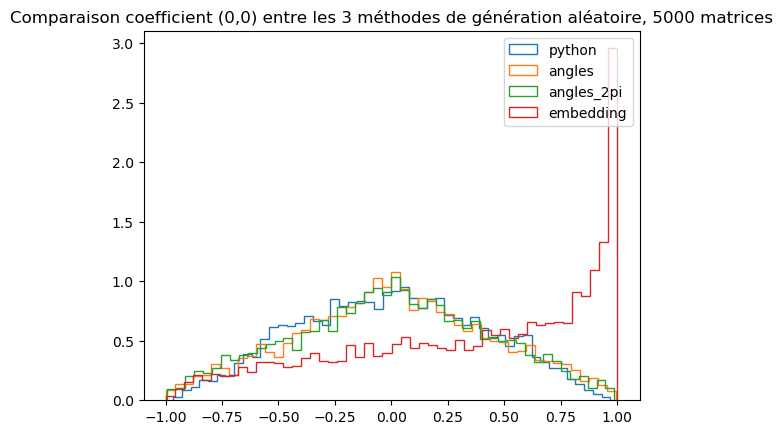

In [48]:
coef00_python = [m[0][0] for m in matrices_python]
coef00_gene = [m[0][0] for m in matrices_gene]
coef00_gene2pi = [m[0][0] for m in matrices_gene2pi]
coef00_embedding = [m[0][0] for m in matrices_embedding]

plt.figure()
plt.title("Comparaison coefficient (0,0) entre les 3 méthodes de génération aléatoire, "+  str(len(matrices_python)) +" matrices")
plt.hist(coef00_python, bins=50, density=True, label="python", histtype="step");
plt.hist(coef00_gene, bins = 50, density=True, label="angles",histtype="step");
plt.hist(coef00_gene2pi, bins = 50, density=True, label="angles_2pi",histtype="step");
plt.hist(coef00_embedding, bins = 50, density=True, label="embedding",histtype="step");
plt.legend()

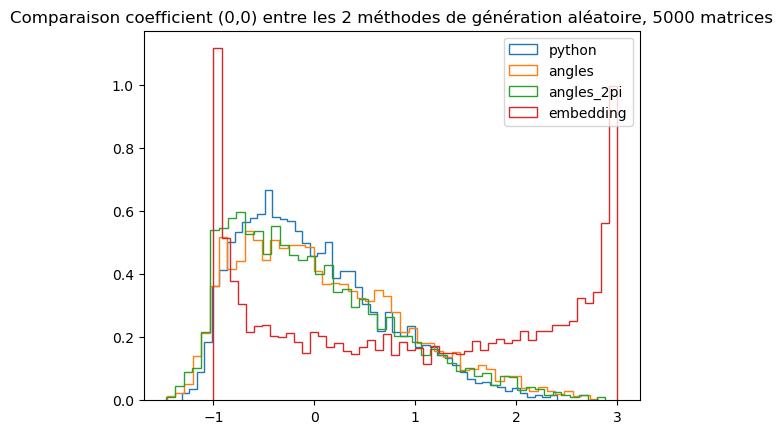

In [49]:
ret_python = [retr(m) for m in matrices_python]
ret_gene = [retr(m) for m in matrices_gene]
ret_gene2pi = [retr(m) for m in matrices_gene2pi]
ret_embedding = [retr(m) for m in matrices_embedding]

plt.figure()
plt.title("Comparaison coefficient (0,0) entre les 2 méthodes de génération aléatoire, "+  str(len(matrices_python)) +" matrices")
plt.hist(ret_python, bins=50, density=True, label="python", histtype="step");
plt.hist(ret_gene, bins = 50, density=True, label="angles",histtype="step");
plt.hist(ret_gene2pi, bins = 50, density=True, label="angles_2pi",histtype="step");
plt.hist(ret_embedding, bins = 50, density=True, label="embedding",histtype="step");
plt.legend()

In [50]:
nb = 1000

matrices_python = []
matrices_gene = []
matrices_gene2pi = []
matrices_embedding = []

for i in range(nb):
    if (i%3000 == 0):
        print(str(i)+" matrices générées...")
    m = generate_su3_matrix()
    m2 = mat_rand_su3()
    m3 = mat_rand_su3_2pi()
    m4 = mat_rand_su3_embedding()
    matrices_python += [m]
    matrices_gene += [m2]
    matrices_gene2pi += [m3]
    matrices_embedding += [m4]
print("Fini !")

0 matrices générées...
Fini !


In [51]:
import itertools

dist_python = []
dist_gene = []
dist_gene2pi = []
dist_embedding = []
compteur = 0
print("Début du calcul :")
for combination in itertools.product(range(nb), range(nb)):
    i,j = combination
    u1_python = matrices_python[i]
    u2_python = matrices_python[j]
    u1_gene = matrices_gene[i]
    u2_gene = matrices_gene[j]
    u1_gene2pi = matrices_gene2pi[i]
    u2_gene2pi = matrices_gene2pi[j]
    u1_embedding = matrices_embedding[i]
    u2_embedding = matrices_embedding[j]
    
    dist_python += [np.sqrt(np.trace((u1_python-u2_python)@np.conjugate(u1_python-u2_python).T))]
    dist_gene += [np.sqrt(np.trace((u1_gene-u2_gene)@np.conjugate(u1_gene-u2_gene).T))]
    dist_gene2pi += [np.sqrt(np.trace((u1_gene2pi-u2_gene2pi)@np.conjugate(u1_gene2pi-u2_gene2pi).T))]
    dist_embedding += [np.sqrt(np.trace((u1_embedding-u2_embedding)@np.conjugate(u1_embedding-u2_embedding).T))]
    if(compteur%100000==0): 
        print(str(compteur)+" couples calculés...")
    compteur +=1
print("Fini !")

Début du calcul :
0 couples calculés...
100000 couples calculés...
200000 couples calculés...
300000 couples calculés...
400000 couples calculés...
500000 couples calculés...
600000 couples calculés...
700000 couples calculés...
800000 couples calculés...
900000 couples calculés...
Fini !


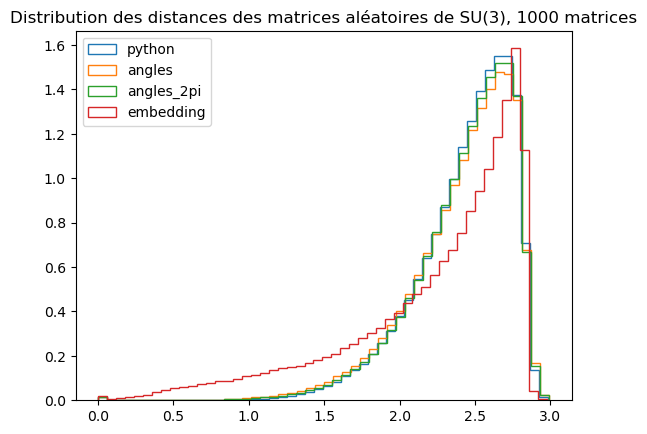

In [52]:
plt.figure()
plt.hist(dist_python, bins=50, density=True, label="python", histtype="step");
plt.hist(dist_gene, bins=50, density=True, label="angles", histtype="step");
plt.hist(dist_gene2pi, bins=50, density=True, label="angles_2pi", histtype="step");
plt.hist(dist_embedding, bins=50, density=True, label="embedding", histtype="step");
plt.legend(loc = "upper left");
plt.title("Distribution des distances des matrices aléatoires de SU(3), "+  str(len(matrices_python)) +" matrices");

In [56]:
def dv(beta,theta,b):
    return np.sin(2*beta)*np.sin(2*b)*np.sin(2*theta)* np.sin(theta)*np.sin(theta)

In [57]:
from scipy.integrate import tplquad

# Définir la fonction à intégrer
# Exemple : f(x, y, z) = x * y * z
# Intégrer f(x, y, z) sur :
# x entre [0, 1]
# y entre [0, 2]
# z entre [0, 3]
result, error = tplquad(dv, 0, 2*np.pi,            # Limites pour x
                        lambda x: 0, lambda x: 2*np.pi,  # Limites pour y
                        lambda x, y: 0, lambda x, y: 2*np.pi)  # Limites pour z

print("Résultat :", result)
print("Erreur estimée :", error)

Résultat : -5.985001224997328e-19
Erreur estimée : 2.799819744274428e-14
